In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()
set_chinese_font()

# 1. Data Wrangling

In [3]:
data = []
for year in range(2008,2015):
    file = "./data/movie_list_%s_v2.json" % year
    with open(file, encoding='utf-8' ) as data_file:    
        data += json.load(data_file)
    
df = pd.DataFrame(data)
df.head()

,detail_url,douban_info,movie_tt_id,name,omdb_info
0,http://www.movieinsider.com/m2401/one-missed-c...,{'alt': 'https://movie.douban.com/subject/2051...,tt0479968,One Missed Call,"{'Response': 'True', 'Year': '2008', 'Country'..."
1,http://www.movieinsider.com/m3221/the-pirates-...,{'alt': 'https://movie.douban.com/subject/1939...,tt0475998,The Pirates Who Don't Do Anything: A VeggieTal...,"{'Response': 'True', 'Year': '2008', 'Country'..."
2,http://www.movieinsider.com/m2828/in-the-name-...,{'alt': 'https://movie.douban.com/subject/1428...,tt0460780,In the Name of the King: A Dungeon Siege Tale,"{'Response': 'True', 'Year': '2007', 'Country'..."
3,http://www.movieinsider.com/m3101/first-sunday/,{'alt': 'https://movie.douban.com/subject/2024...,tt0486578,First Sunday,"{'Response': 'True', 'Year': '2008', 'Country'..."
4,http://www.movieinsider.com/m1023/teeth/,{'alt': 'https://movie.douban.com/subject/1962...,tt0780622,Teeth,"{'Response': 'True', 'Year': '2007', 'Country'..."


In [4]:
# Problem, handling unicode json
df.drop('detail_url', 1, inplace=True)
df.drop_duplicates('movie_tt_id', inplace=True)
df['temp_string'] = df['douban_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df['temp_string'] = df['omdb_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df = df.dropna()
df.drop('temp_string', 1, inplace=True)

In [5]:
df['omdb_info'][0]

{'Actors': 'Shannyn Sossamon, Edward Burns, Ana Claudia Talancón, Ray Wise',
 'Awards': '2 nominations.',
 'Country': 'Japan, USA, Germany',
 'Director': 'Eric Valette',
 'Genre': 'Horror, Mystery',
 'Language': 'English',
 'Metascore': '24',
 'Plot': 'Several people start receiving voice-mails from their future selves - messages which include the date, time, and some of the details of their deaths.',
 'Poster': 'http://ia.media-imdb.com/images/M/MV5BMjA2NTk0OTcyMV5BMl5BanBnXkFtZTcwMzk1MDU1MQ@@._V1_SX300.jpg',
 'Rated': 'PG-13',
 'Released': '4 Jan 2008',
 'Response': 'True',
 'Runtime': '87 min',
 'Title': 'One Missed Call',
 'Type': 'movie',
 'Writer': 'Andrew Klavan (screenplay), Yasushi Akimoto (novel), Minako Daira (screenplay)',
 'Year': '2008',
 'imdbID': 'tt0479968',
 'imdbRating': '3.9',
 'imdbVotes': '24943'}

In [6]:
df['douban_info'][1]

{'aka': ['蔬菜海盗历险记', '无所事事的海盗'],
 'alt': 'https://movie.douban.com/subject/1939774/',
 'casts': [{'alt': None, 'avatars': None, 'id': None, 'name': 'Phil Vischer'},
  {'alt': None, 'avatars': None, 'id': None, 'name': 'Mike Nawrocki'},
  {'alt': 'https://movie.douban.com/celebrity/1076005/',
   'avatars': {'large': 'http://img6.douban.com/f/movie/63acc16ca6309ef191f0378faf793d1096a3e606/pics/movie/celebrity-default-large.png',
    'medium': 'http://img6.douban.com/f/movie/8dd0c794499fe925ae2ae89ee30cd225750457b4/pics/movie/celebrity-default-medium.png',
    'small': 'http://img6.douban.com/f/movie/ca527386eb8c4e325611e22dfcb04cc116d6b423/pics/movie/celebrity-default-small.png'},
   'id': '1076005',
   'name': 'Cam Clarke'},
  {'alt': None, 'avatars': None, 'id': None, 'name': 'Laura Gerow'}],
 'collect_count': 809,
 'comments_count': 121,
 'countries': ['美国'],
 'current_season': None,
 'directors': [{'alt': None,
   'avatars': None,
   'id': None,
   'name': 'Mike Nawrocki'}],
 'do_coun

In [7]:
# Data problems
# 1.['imdb_info']['imdbRating'] do not exist
# 2.['imdb_rating'] is 'N/A', at id 108, 273
# 3.['imdb_rating'] is '23,421', need to get rid of the comma

df['imdb_rating'] = df['omdb_info'].apply(lambda x: x.get('imdbRating', np.nan))
df['metascore'] = df['omdb_info'].apply(lambda x: x.get('Metascore', np.nan))
df = df.dropna()
df = df[(df.imdb_rating != 'N/A') &(df.metascore != 'N/A')]

df['year']=df['omdb_info'].apply(lambda x: x.get('Year', np.nan))
df['year'] = df['year'].astype(float)
df['imdb_ratings_count'] = df['omdb_info'].apply(lambda x: int(x['imdbVotes'].replace(',', '')))
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['imdb_ratings_count'] = df['imdb_ratings_count'].astype(int)
# df['name'] = df['name'].apply(lambda x: x.encode('ascii','ignore'))
df['metascore'] = df['metascore'].astype(float)
df['metascore'] = df['metascore']/10
df['genre']=df['omdb_info'].apply(lambda x: x.get('Genre', 'none'))
df['country']=df['omdb_info'].apply(lambda x: x.get('Country', 'none'))
# df['genre'] = df['genre_all'].apply(lambda x: x)
# # df['country'] = df['country_all'].apply(lambda x: x.split(',')[0])
# df['country'] = df['country_all'].apply(lambda x: x)

df['name'] = df['douban_info'].apply(lambda x: x['title'])
df['db_rating'] = df['douban_info'].apply(lambda x: x['rating']['average'])
df['db_ratings_count'] = df['douban_info'].apply(lambda x: x['ratings_count'])
df['image_url']=df['douban_info'].apply(lambda x: x['images']['large'])
df['douban_url']=df['douban_info'].apply(lambda x: x['alt'])
df['douban_year']=df['douban_info'].apply(lambda x: x['year'])
df['genre_douban']=df['douban_info'].apply(lambda x: x['genres'])
df['country_douban']=df['douban_info'].apply(lambda x: x['countries'])

df.drop('douban_info', 1, inplace=True)
df.drop('omdb_info', 1, inplace=True)

In [8]:
df['year'].value_counts()

2011.0    428
2012.0    406
2010.0    384
2009.0    350
2013.0    348
2008.0    288
2014.0    210
2007.0     58
2006.0     10
2004.0      4
1994.0      2
1999.0      2
2001.0      1
1995.0      1
2003.0      1
1993.0      1
1992.0      1
1987.0      1
1982.0      1
1981.0      1
1978.0      1
1962.0      1
1954.0      1
1939.0      1
Name: year, dtype: int64

# 2. Movie Overview

In [9]:
df.describe()

,imdb_rating,metascore,year,imdb_ratings_count,db_rating,db_ratings_count
count,2502.000000,2502.000000,2502.000000,2.502000e+03,2502.000000,2502.000000
mean,6.374221,5.441647,2010.620703,5.662486e+04,6.085651,20699.289768
std,0.993491,1.721034,3.179870,1.093372e+05,2.324885,50322.771295
min,1.600000,0.100000,1939.000000,1.200000e+01,0.000000,0.000000
25%,5.800000,4.200000,2009.000000,2.821000e+03,5.900000,235.000000
50%,6.450000,5.500000,2011.000000,1.350950e+04,6.700000,2592.500000
75%,7.100000,6.700000,2012.000000,6.073825e+04,7.500000,14463.750000
max,9.000000,10.000000,2014.000000,1.451699e+06,9.500000,586362.000000


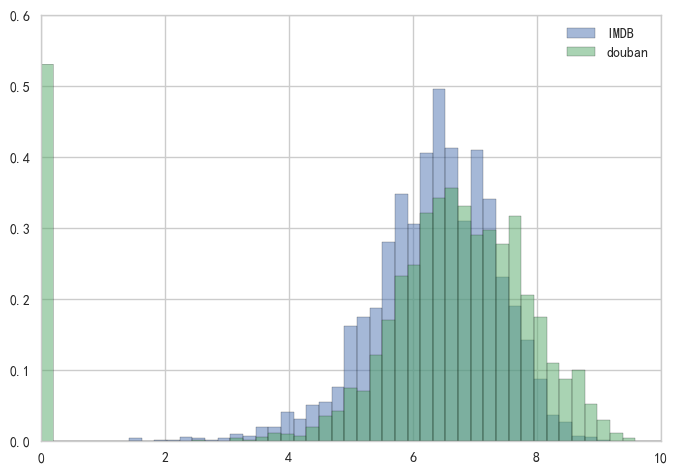

In [10]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

可以发现，有的电影豆瓣电影没有分数。应该把这些去掉

（可以看看这些电影是什么样的）

## 2.1 Empty Score Moives

In [11]:
empty_df = df.query('db_rating == 0')
display(empty_df.describe())
fig=plt.figure()
empty_df['imdb_rating'].hist(bins=arange(-0.05,10,0.1), alpha=0.5)
plt_configure(title='No Douban rating, IMDB Rating Distribution',figsize=(3,2))
fig=plt.figure()
empty_df['imdb_ratings_count'].hist(bins=50)
plt_configure(title='No Douban rating, IMDB Rating Count Distribution', figsize=(3,2))
align_figures()

,imdb_rating,metascore,year,imdb_ratings_count,db_rating,db_ratings_count
count,271.000000,271.000000,271.000000,271.000000,271.0,271.000000
mean,6.054613,5.182288,2010.874539,705.239852,0.0,7.276753
std,1.127225,1.639032,2.270368,1188.621094,0.0,6.237356
min,2.300000,0.900000,1987.000000,12.000000,0.0,0.000000
25%,5.400000,4.000000,2010.000000,182.000000,0.0,2.000000
50%,6.200000,5.300000,2011.000000,422.000000,0.0,5.000000
75%,6.900000,6.450000,2012.000000,761.000000,0.0,12.000000
max,8.400000,8.600000,2014.000000,13492.000000,0.0,23.000000


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXEAAADUCAYAAABqIRNNAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3XtYE3e6B/BvCHcpERRRkEW8EUpRsOJl21pqrHjWesHV
ellrrauruNq1FbdSbbFqW9C1Fxcv1J6toEXLpajruq6P2p7qqai7Vq2toIJ0WSBcDHeSAMmcPziZ
EgghgcBceD/P4xNn5jcz78wkL7/MTOaVMAzDgBBCiCDZcR0AIYSQrqMkTgghAkZJnBBCBIySOCGE
CBglcUIIETBK4oQQImCUxAkhRMAoiRNCiIBREieEEAGzOIlnZWVBLpcjPT2dHVdUVAS5XI4TJ07Y
JJhr165BLpdDLpcjLCwMCxYsQEZGhk2W3XYdVVVVNl0un127dg1BQUFch9EpuVyOlJQUo3GJiYmQ
y+XYuXMnO27Hjh2Qy+VITExk55PL5QgJCUFkZCQ++ugjaDQatn1sbCzbJigoCFOnTkVCQgK0Wq1V
sbV+by5cuBCXLl3q5habxuXxeumllyCXyxEcHIwpU6YgNjYWxcXFHbY1HAOuJCYmYtmyZe3GT506
FZ999lmvxJCVlQWFQtEr6zLF6p74559/3hNxsCQSCT744APs378fQUFB2Lp1q83fKBKJxKbL41JR
UVGn++eJJ56w+R/D3pabm2v0/7bHcMWKFUhOTsa8efOQnJyMNWvWGE0PCAjAl19+iYyMDLz++uv4
8ssv8cEHH1gVw/Lly5GZmYmPPvoInp6eWL16Nf75z39atQwhHK8JEybg2LFj2LBhA65du4aFCxfi
0aNH7drt2LEDCxcu7PJ6kpOTkZOT051QsXDhQmzfvr1byzAnJycHycnJZttMnToVBw8e7LEYOmN1
Es/NzbX6jWut4cOHY/Lkydi+fTuWLFmCpKQkqFSqHl2nUFmSFFxdXREcHNxLEfWMe/fumfy/weDB
gzFu3DisXr0a77//PrKzs3H+/Hl2urOzMx5//HEEBwfjhRdewNKlS/G3v/3Nqhi8vb0RHByMZ599
Fnv37oWXlxeysrKsWoYQjpe7uzvGjBmDefPm4ciRI6irq0NSUlK7dsOGDYOXl1eX12OLJO7l5YVh
w4Z1axnm3L17t923w7ZkMhlGjRrVYzF0xuok7u3tjaNHj/ZELCb95je/QVNTU499dRU6hmFE9c3C
lLFjx6Kurg5KpRLFxcWoq6vDE0880WH7GTNmYODAgfjqq6/MLrexsbHLMTk4OCAwMBBKpdKq+YR2
vHx8fBAREdHpvhQrITwf0KokLpFIsGjRIpw/fx5lZWUm22RlZSEyMhJjxozBokWL8P3333crwBEj
RsDJyQn5+fnsuP/5n//B7NmzERISgjlz5hgl+KysLEydOtVoGYbz4K19/fXXmDZtGsLCwvD666+j
rq7OaPrhw4cxbdo0hIaGYu7cubhy5Qo7LTExES+99BJu3ryJefPmITQ0FIsWLcJ//vMfq7ZNLpfj
+vXruHDhAl588UX87ne/M5p++/ZtLF26FGFhYZgyZQr27NljFINcLsfLL7/MLksulyM2Nrbdekxt
v6XbUVNTgw0bNmD8+PF44YUX8MknnyAyMhK7d++2alu7w9HREb/4xS+Qk5OD3Nxc+Pn5wcXFxew8
crkceXl5Jqf9+OOPyMjIwHPPPdetuCoqKuDp6ckOi/V4BQUFoaioqN0fvY7Oiet0OiQkJGDKlCkI
CwvD0qVL2dNhhutocrkcxcXF2Lx5M3utou22Llu2DLW1tXj77bfx9NNPmzwDYNgnplRUVGDlypUY
M2YMZs+ejevXr5udr3XuMFxHefPNN1FcXMzGaGp7TeUcg1u3bmHRokUYM2YMIiMjcfLkSXaa4ThX
VFRgzZo1CAsLw/Tp063usFrdE4+KioKLiwuOHTvWbtqXX36JLVu2YObMmUhKSsKgQYOwbNkyPHz4
0NrVGHF3d0d1dTUA4MqVK4iOjsaTTz6JQ4cOISwsDGvWrDE6QKZ6Oq3HMQyDPXv2YNOmTXj33XeR
nZ2NuLg4dvpf//pX7N69G6+88gr+8pe/YNy4cXj11VfR0NDAtikpKcGrr76KF198ER9//DGUSmWX
PihnzpzBtm3bMGXKFLz44ovs+Pr6eqxatQr9+/fHp59+ijfeeANHjx7FqVOnALScC8zMzMQ777wD
oGXfZ2ZmYv369SbX01Hvr7Pt2LVrFwoLC7F//35ERERg79692LlzJxYsWGD1tnbH6NGjkZOTg5yc
HIwePbrT9jKZDDU1Nezw3bt32eQxb948eHl5sfvOWhqNBsnJybh79y6ef/55AOI+Xv379wfDMKit
rbWo/ZEjR3D06FFs3LgR+/fvh7u7O1577TUAwKBBg5CZmYnMzEx4eXlh3bp1yMzMNHkNoLGxES+/
/DIqKiqwdu1a/OIXvzC5vo72VXJyMuRyOZKSkjBkyBBER0ejsrLS7HyGcevXr0dmZibWrVsHLy8v
9npKR9cATC3rwYMHWL58Oby9vZGUlIRf/epXiI2NxV//+lejdqtWrcLw4cNx4MAB+Pj4YPPmzSbX
0RF7q1oD6NevH+bNm4f09HTMmTPHaFpiYiLmzJmDV199FQAQHh6OmTNn4tChQ3jvvfesXRVLIpGw
X2v27duHJ598kk26kyZNQl5eHhITEzu9ANHa66+/jsjISAAtH8C4uDjExsZi4MCB8PHxwUcffcR+
QO3t7XHs2DHk5eUhJCQEQEuP4s9//jOmTZsGoKVXkpaWZvW2nT17Funp6Rg6dKjReI1Gg02bNkGh
UMDDwwNarRb//d//jZs3b2L27Nnw8vKCl5cX6uvrAQCPP/641eu2ZDtu3bqF3/zmN5gwYQLGjh2L
Tz/9FI6Ojj16HrItiUTCJnEACAwMxNWrVzudp/VX4YCAAHz00Udobm7GrVu38OGHHyIhIcHoj3dn
du3ahYSEBACAk5MToqOjMX36dADiPl6GBGXpqYWioiIMHDiQzQ+jR4/GnTt3ALSchjKc73dwcMDQ
oUM7PP9/8+ZNLF++3OqkZhAWFoaYmBgAQEhICJ5++mlkZGRg1apVnc7r4+MDHx8f3Lt3Dw4ODl06
XocOHYKXlxc++OADSKVSTJ48GUqlEh9//DFmzZrFtgsPD8cf//hHAC359cUXX0RZWRkGDRpk0Xq6
dJ/40qVLUVlZiTNnzrDjVCoViouLMXHiRHacvb09xo8f3+1TKrW1tejfvz8A4IcffjBaBwBMnjzZ
7Dr0er3RsEQiwfjx49nhkJAQMAyDn376CQDw5JNPwsHBAW+99RZmzpyJJUuWAIDRbWteXl7sBwkA
PD090dzcbPW2rVq1ql0CB4ABAwZgwoQJOHLkCF566SVMmjQJubm5UKvVVq/DnM62IyAgAP/7v/+L
hoYGXLhwAQ4ODvD397dpDJYIDAxEbm4ucnNzERgY2Gn76upqyGQydtjZ2RmBgYEIDg7GkiVLsH79
enzxxRcoLS21OIbly5fjxIkTmDZtGgYOHIjf//737DQxH6+qqipIJBK4u7tb1H7OnDmora3FzJkz
sX37dly9ehWTJ0+2er2enp7YsGGD1fMZhIeHs/93c3NDQEAA+xk3pW2e6K4ffvgBTz75JKRSKTtu
0qRJKCoqYm9xlkgkWLp0KTvdcHrOmlzSpSTu5+eHKVOm4IsvvujxizQFBQVQq9Xs1d+OegPmegkl
JSXtxtnZ/bzpUqkUDMOwBzEhIQGvv/46+zXwm2++abf8jr7aWcvQs2/r+++/xwsvvICcnBzMnj0b
x44dw+zZs22yztY6246goCBcvnwZ48aNw5tvvolt27axf1B70+jRo/Hw4UMUFBRYdDolNzfXbDt/
f38wDGPVhcl

In [13]:
empty_df.sort_values(by='imdb_ratings_count',ascending=False).head()

,movie_tt_id,name,imdb_rating,metascore,year,imdb_ratings_count,genre,country,db_rating,db_ratings_count,image_url,douban_url,douban_year,genre_douban,country_douban
1964,tt1520498,气球大冒险,7.2,3.2,2012.0,13492,"Adventure, Family",USA,0.0,0,http://img3.douban.com/lpic/s9066428.jpg,http://movie.douban.com/subject/4067243/,2012,[家庭],[美国]
2935,tt2967006,意大利之旅,6.7,7.5,2014.0,8567,"Comedy, Drama",UK,0.0,11,http://img3.douban.com/view/movie_poster_cover...,http://movie.douban.com/subject/25864254/,2014,"[剧情, 喜剧]","[英国, 意大利]"
285,tt0886539,偶然运气,7.1,5.8,2009.0,6528,Drama,India,0.0,22,http://img6.douban.com/lpic/s3830167.jpg,https://movie.douban.com/subject/3345508/,2009,[剧情],[印度]
227,tt0479162,特殊病人,7.0,5.7,2006.0,4707,"Comedy, Drama, Sci-Fi",USA,0.0,6,http://img3.doubanio.com/lpic/s3339437.jpg,https://movie.douban.com/subject/3278714/,2006,"[剧情, 奇幻]",[美国]
854,tt1396557,温尼贝戈人,7.2,7.1,2009.0,3564,"Documentary, Biography, Comedy",USA,0.0,12,http://img3.douban.com/lpic/s4396761.jpg,http://movie.douban.com/subject/3794525/,2009,"[纪录片, 喜剧]",[美国]


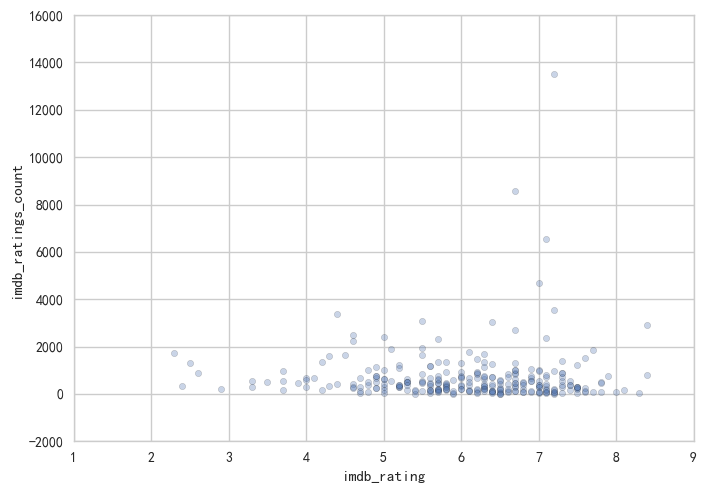

In [14]:
empty_df.plot(kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)

## 2.2 Delete Empty movies, Go ahead

In [15]:
df = df.query('db_rating > 0')

# 3. Movie Overview (两种评分都有的)

## 3.1 Overall Info

In [16]:
coloumn = df['db_rating']
std, mean = coloumn.std(), coloumn.mean()
df['db_rank_norm']=(coloumn-mean)/std
coloumn = df['imdb_rating']
std, mean = coloumn.std(), coloumn.mean()
df['imdb_rank_norm']=(coloumn-mean)/std

df = df.query('year > 2005')
df.describe()

,imdb_rating,metascore,year,imdb_ratings_count,db_rating,db_ratings_count,db_rank_norm,imdb_rank_norm
count,2214.000000,2214.000000,2214.000000,2.214000e+03,2214.000000,2214.000000,2214.000000,2214.000000
mean,6.400949,5.453794,2010.773261,6.060259e+04,6.814318,22500.938121,-0.010483,-0.012480
std,0.961540,1.715226,1.948985,1.064254e+05,1.002833,51213.475986,0.995611,0.992171
min,1.600000,0.100000,2006.000000,1.580000e+02,2.600000,20.000000,-4.194451,-4.966372
25%,5.800000,4.200000,2009.000000,4.815500e+03,6.200000,613.500000,-0.620377,-0.632573
50%,6.500000,5.500000,2011.000000,1.838700e+04,6.800000,3673.500000,-0.024698,0.089727
75%,7.100000,6.700000,2012.000000,6.914425e+04,7.500000,17532.000000,0.670261,0.708841
max,9.000000,10.000000,2014.000000,1.451699e+06,9.500000,586362.000000,2.655858,2.669369


In [17]:
df['year'].value_counts()

2011.0    363
2010.0    342
2012.0    337
2009.0    326
2013.0    312
2008.0    274
2014.0    200
2007.0     53
2006.0      7
Name: year, dtype: int64

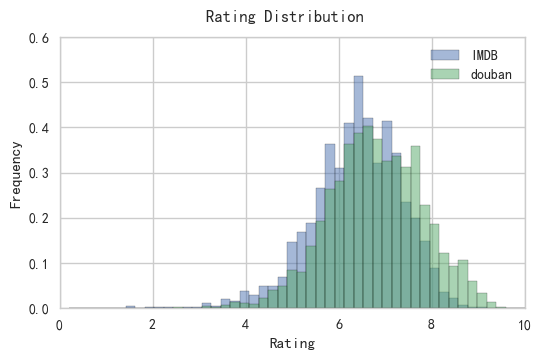

In [18]:
# 1. Why douban is higher?
# 2. Why the std is close to 1? (but IMDB < Douban, indicating a narrower distribution)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True, figsize=(6,3.5))

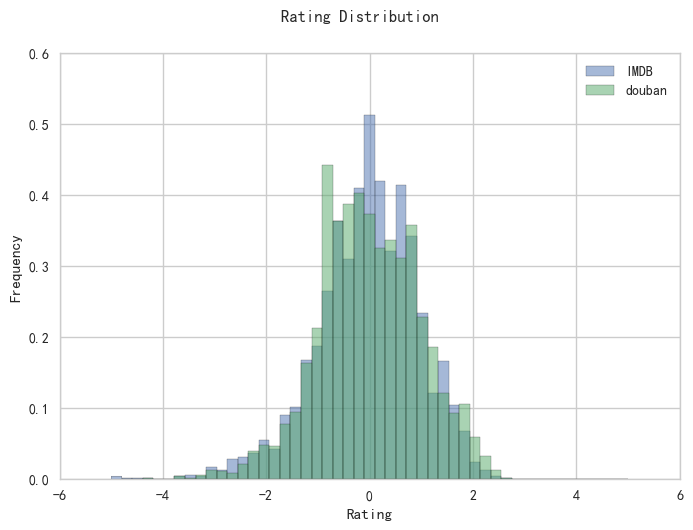

In [19]:
bins=linspace(-5,5)
df['imdb_rank_norm'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rank_norm'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

1. 两者大致分布正态分布，可以认为样本量基本足够
2. 这不是标准的正态分布，有偏度。原因？
3. 豆瓣电影偏高（相对有移动了）

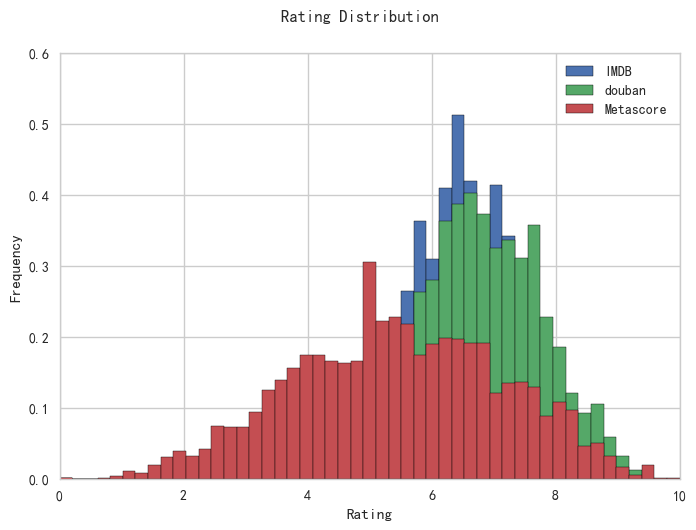

In [20]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=1, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=1,  normed=True, label = 'douban')
df['metascore'].hist(bins=bins, alpha=1, normed=True, label = 'Metascore')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

并不是所有的影评分布都会类似. 比如Metascore的分布，就大为不同

Metascore的分数经过了人工的调整、加权，所以分布差别很大

## 3.3 Scatter Comparison

scatter,可以非常直观的比较两者的差别

 
0.7511 x + 1.283


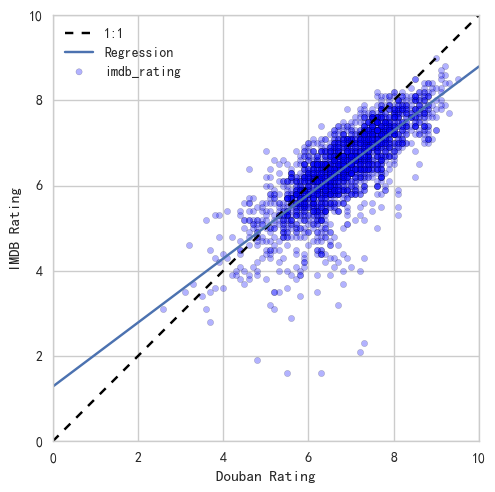

In [21]:
fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(df, title='', type='rating')
print(fit_fn)
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_all.html')

对比回归线，可以看到
1. 并不是1:1的关系，斜率不同（原因？可能是打分制？），而且分数越高，差别越大

    - IMDB: 10星制。没有人会打10星  
    - 豆瓣：5星制。4星以上都会打5星
    
    豆瓣的打分制概念简单，不需要太精确，体验更好。

2. IMDB比豆瓣要齐整得多。豆瓣确实有一些电影，偏离回归线较大[(4,6)附近]

3. Play with the scatter, 发现“打分人数”的问题

## 3.4 Rating Number Problem

In [22]:
for min_ratings_number in [0, 1000,3000,5000,10000, 20000,40000]:
    min_ratings_number = min_ratings_number
    temp_df = df.query("(db_ratings_count > @min_ratings_number) & \
                   (imdb_ratings_count > @min_ratings_number)")
    title = 'Min Rating: ' + str(min_ratings_number) + ' N:' + str(len(temp_df))
    fig, fit_params, _ = plot_movie_scatter_comparison(temp_df, title=title, type='rating')
    fig.set_size_inches(2.5,2.5)
    fig.show()
    print(min_ratings_number, fit_params[1], len(temp_df))
align_figures()

D:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0 0.751111112013 2214
1000 0.780824288134 1528
3000 0.788167598862 1167
5000 0.801933540873 966
10000 0.808246822772 704
20000 0.792454771888 485
40000 0.772679888259 303


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQcAAAESCAYAAADwsBCPAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXd4VGXauO8zNZlMeq8kJKRQQu+itGADCzZ0Rdn1tyo2
LLsiri4WLLC6+2FDsXyui6wgLIgoawERlBY6kSSQSnqfZDK9nN8fbxKIBEiAQPic+7q4wpwz553n
TPI+53mf9kqyLMt48ODBw69QXGwBPHjw0DPxKAcPHjx0iEc5ePDgoUM8ysGDBw8d4lEOHjx46BCP
cvDgwUOHeJSDBw8eOsSjHDx48NAhHuXgwYOHDvlNK4c1a9aQmprK7Nmz24599NFHpKamMm/evHbv
3bVrF2lpad0iR2pqatu/wYMHc9ttt7F169Zu+azuvI/zgcFg4LHHHmPYsGFMmzaNXbt2den6iRMn
MnHiRE5M/H3qqaeYOHFip8eoq6vj4YcfZsiQIQwcOJD77ruP2tradu/54IMPuOKKK+jfvz9XXnkl
mzdv7nCsf/zjHyf9LXXEAw880Kn3XUh+08qhldzc3Hb/lyTppPf079+fVatWdZsMs2bNYvXq1fzP
//wPQUFB3HfffezevbtLY5SVlfHWW2+d9j3dfR/nykMPPcSBAwdYuHAhN910E/fffz9lZWVdGqOi
ooKNGze2vZYkqcPf6elkyMrK4vHHH+eJJ55g//79PPnkk23nV65cyT/+8Q8yMjJ4+eWXCQ0N5ZFH
HqGkpKTdOOvXr2fp0qVn/Lz169ezadOmTst3oVBdbAF6AhUVFTQ3N6PX69spihPR6XT069ev22QI
Dw9vG3/MmDFMnjyZNWvWMGzYsE6P0aocHnrooVO+p7vv41z46aef2LNnD59//jn9+/cHICcnh48+
+ohnn322S2MtW7aMyZMnd1mGn3/+mdzcXDZs2EB4eDgAWq2W5557DqPRiI+PD0uWLOHJJ5/k7rvv
BoS1MmbMGH744QfuuusuAD777DMWLVpEUlLSaT+vvr6el156CV9f3y7L2t385i2HqKgoQkNDycnJ
wel0kp+fT3p6+kWVSa1Wk5KSQmVlZZeuk2W5S0/InsaOHTuIi4trUwwAkyZNYtu2bV0aJzw8nJ07
d5Kfn99lGQYOHMjnn3/ephgAAgICAHC73UiSxJIlS7jjjjvazuv1etRqNW63u+3YoUOH+Pjjj9vd
S0c8//zzJCUlnZUi625+88oBIDk5mdzcXAoKClAoFMTHx5/0nl27dpGamnrS8bfeeouZM2eyf/9+
pk+fzqBBg5gxYwalpaXnJFNtbS1BQUFtrw8ePMidd97J4MGDufzyy3n99dfbyZCamtr2JGv1X3S0
hj2X+2hqauLRRx9l2LBhTJ06laVLl3LllVfyt7/9rd1Y8+bN48Ybb+zyPVdVVZGSktLuWGxsLKWl
pXSleHjSpEmEhoaybNmy074vNTWVTz75pN0xvV5PYmJiu2M//vgj8fHx+Pv7I0kSqampqNXqtvO7
d+/GbDYzePDgtmMvvfTSGR8y3377LVu3buWVV17p7K1dUDzKAaEccnJyyMnJITExEYWi46/lVE/l
iooKHnnkEW699VYWL15MZWXlSROms1itVv75z3+SnZ1NRkYGACaTiT/+8Y8EBATwwQcfMHfuXJYt
W8a6desAuO2221i9ejXPP/88AP/5z39YvXo1Dz/88Hm9j0WLFlFSUsI777zD+PHjeeONN1iwYAG3
3HJLu3EefvhhXnvttS7fu81mw8/Pr90xnU6H0+mkqamp0+OoVCpuv/12vvjiC5qbm0/5vtWrVzN1
6tTTjlVcXMy6dev4/e9/f8r3vPHGGwwcOJCBAwd2WkaDwcALL7zAk08+SUxMTKevu5D85n0OkiSR
nJzMp59+ip+f30lPrs5QVlbGm2++2WYazpw5k5UrV3ZpjEWLFrFw4UJArHFnz57NlClTAKEw/vzn
PzNp0iQCAwOx2Wx8+OGH7N+/n+uuu47Q0FBCQ0MxmUwA9O3bt8v30Jn7OHDgAL/73e8YMWIEAwcO
5IMPPkCj0ZxkaUVFRZ3V56vV6pMUc6sis1qt+Pv7d3qs2267jSVLlrB69epTvudMvhdZlnn66adJ
Skripptu6vA9K1euZM+ePSxfvrzTsoGwLFJSUpgxY0aXrruQeCwHICUlhby8PHJycs5KOYSGhrZb
MwYFBeF0Ors0xqxZs1i7di2TJ08mJCSEBx98sO1ccHAwI0aM4F//+hczZ85k1KhR5ObmYrFYuizr
6TjTfSQkJPDzzz9jNpvZuHEjarWaXr16nbfPDw4Opqqqqt2xhoYGQFgQXSEoKIhrrrmG5cuXd2lJ
ciJLly4lKyuLRYsWoVQqTzpfWFjIwoUL+X//7/91yWrYvHkzmzZtYsGCBWcl14XCoxyAxMRE7HY7
27ZtIzk5ucvXx8XFnbMMYWFhpKamMmfOHMrLy/niiy/azh06dIipU6eSk5PDddddx7///W+uu+66
c/7MX3Om+0hLS+Onn35iyJAhPP300zz33HNtzrrzQWpqKgcPHsTlcrUdy8rKwsvL66y8+XfddRfF
xcVs3769y9du376dN954g6eeeqrDvwmLxcIjjzxCSkoKjzzySJfG/uabbzCbzUyYMKHNP7RmzRrW
rFlDWloa5eXlXZa3O/jNLysANBoNcXFxFBUVnZVyOJWP4mzo06cPGRkZLF26lBtvvBFJkli/fj2h
oaG88847be8rLCwkISGh3bVarRYQXvWzkel019TX1/PWW2+xc+dO6uvrCQsLw8vLq8ufcTomTJjA
/PnzWblyJbfffjt2u50VK1YwevTosxqvb9++DBkyhL179xIdHd3p6/Ly8nj00Ue55ppruP322086
73a7mTNnDg0NDXz44YcdWhWnY86cOW3O41YWL16MJEnMmTOHsLCwLo3XXXiUQwvJyck0NjYSEhJy
sUXhgQce4MYbb+Trr7/m2muvJTAwkJqaGjZs2IBOp2PZsmUcOHDgpCd9YmIiPj4+LF26lFGjRnH4
8GGuuuqqdlGPs0WpVCJJEu+//z7jxo3DbDYTGBjYLuTXSllZGVar9SSv/5kIDAzkgQce4KWXXmLn
zp0UFRWRn5/Pyy+/fNZyz5w5k71793Z4Lisri6ioqHbfj9Pp5JFHHkGtVnPbbbeRlZXVdi4hIQEf
Hx/ee+89tmzZwty5c6murqa6urpN/s4ooYiICCIiItoda7XAzmZZ2114lEMLycnJXfKIn09+ncGX
mprKpEmTePfdd7n22mu5++67OXr0KM8++ywqlYopU6YwY8YMtm3b1s5K0Ov1vP7667z88su89dZb
REVFtTk1zxV/f38mTZrEZ599xieffILVakWWZVJSUvjf//3fdhPsrbfeIicnhzVr1nT5c2bPnk1k
ZCQrVqwgKCiIZcuWdSlp69ff5ZQpU4iIiOgwQnPzzTfz9NNPtyUuARw9epTCwkJAKJYT+eSTTxg+
fDj//e9/kSSJRYsWtTt/ww039Niw5NkgebpPe+gMq1at4t133+W5557Dz88Pt9tNbm4uCxYs4I03
3mDChAkXW0QP5xmPcvDQKWpqanj11VfJzMzEYDCgVCqJjY3lqquu4v777z+vfhcPPQOPcvDgwUOH
XFR1X19fz6RJk9qFbo4cOcLNN9/MyJEjzzrL0IMHD+fORVMO9fX1zJ49u51isNvtzJ49mwEDBrBq
1Sry8/PPyqnlwYOHc+eiKYcnnniCadOmtTu2ZcsWmpubeeqpp4iNjeXRRx/l888/v0gSevDw2+ai
KYcFCxZw5513tkttzcnJYdCgQW3JPKmpqWdVduvBg4dz56LlOXSULGIymU6qUFMqlRiNxk6nzzqd
ThobG9FqtR4

对比上面这几张图，可以发现随着评分人数的增加，偏离逐渐收窄，但并不迅速收窄

一直到4W人以上，豆瓣和IMDB才算均衡。也就是说，
- 部分电影的偏离，确实是由于看的人很少，打分不客观引起（打分样本过少）
- 部分偏离的电影，是有相当一部分人观看的 （>3K），这个现象确实存在

### 3.4.1 Ratings Number Distribution (Optional)

In [23]:
# This plot is not very informative, what can I do?
# Why is this kind distribution? -> Poisson
fig=plt.figure()
df['imdb_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
fig=plt.figure()
df['db_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZsAAAE9CAYAAADd3c8LAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3X1cVAW+P/DPcOYhEBwUH1IgWSsYrzs2psiSJgSZlZpS
9KA3a9tXrVJucUNv+HDXCkyJtt3MSrrdmy8sLaFFy3vXLbLyId3s0Z+bSDzZJGQqYDPDcWaA8/uD
68QoTzPM4Rzw8369fOmc75k5nwHHj2fOYY5GkiQJREREMgpSOgAREQ18LBsiIpIdy4aIiGTHsiEi
ItmxbIiISHYsGyIikh3LhoiIZMeyISIi2bFsiIhIdiwboh5auHAhlixZ4rn92WefwWQy4bbbbvMs
e//992EymXDfffd57mMymTB+/HhMnz4dy5cvR21trWf9kpISmEwmz6/ExET84Q9/wI8//th3T4yo
D7BsiHqpuroazc3NAICysrKL5lOmTMHWrVuRmZmJzz77DHfddRfOnDnjmWs0Grzxxht45513kJ+f
jxMnTuCRRx7ps/xEfYFlQ9RLzc3NqKioAAAcO3YMGo3Gaz548GBMmDABt99+OzZv3gyHw4GCggKv
dc7v/UybNg1PPPEEvv32W1RXV/fZcyCSG8uGqJcsFguOHTsGoG3PZsKECZ2uO3r0aCQnJ+Ojjz7q
9nGdTmfAMhIpjWVD1EuxsbEoKyuD3W5HbW0t4uLiulx/3LhxOHHiBFwul2fZ+Q9fP3nyJDZu3Ijo
6GhcddVVsuYm6ktapQMQ9WcajQaxsbHYvXs3jh07hsGDB2PEiBGoqanp9D7h4eGQJAk2mw1AW9HE
x8d7zd98801otXx50sDBPRuiXoqLi0NZWRmOHTuG2NjYbtc/f0zn/N6MRqPBli1bsH37drzwwgsY
NmwYli1bBrfbLWtuor7E/zoR9VJsbCzOnDmD/fv3d/sWGgA0NjZCo9Fg8ODBXo8RGhoKk8mEMWPG
YN68edi1axfmzJkjZ3SiPsM9G6JeOv/W2e7du3tUNmVlZYiOjoZer+9wHhMTAwCoq6sLZEwiRbFs
iALg/Ntn3b2NdvLkSXz00UeYOXNmp+t89913AIARI0YELiCRwvg2GlEAxMbG4tNPP0VsbCz27t3r
Nfv5559x+PBhVFRUYOPGjRg+fDh+//vfe+aSJOHbb7/FZZddBqvVildeeQWDBw9GUlJSXz8NItmw
bIh8cOEPbJ4XGxuLqKgoBAcHXzQ7dOgQFixYgOHDhyM1NRVLlixBaGio12Pef//9AIChQ4di0qRJ
eP755zFkyBB5ngSRAjTS+VNiiIiIZMJjNkREJDuWDRERyY5lQ0REsmPZEBGR7Fg2REQkO5YNERHJ
TtGyqa+vR2pqqtdlctt78MEHsX37ds/t8vJypKenIyEhAfn5+V7rdjUjIiJlKVY29fX1yMjI6LRo
3n33Xezbt89z2+VyISMjA2azGcXFxaisrERJSUm3MyIiUp5iZZOVldXpJ9qePXsWzz77LMaOHetZ
tmfPHtjtdmRnZyM6OhqZmZkoKirqdkZERMpTrGxyc3Nx7733oqMPMFi3bh1mzJiBa665xrOsrKwM
FosFBoMBQNs12ysrK7udERGR8hT7bLTIyMgOlx88eBD/+Mc/sHPnTuTk5HiWOxwOREVFea0rCAJs
NluXs7CwsB7laW5uxtmzZ2EwGBAUxPMmiKj/a21thdPphNFoVPzKr6r6IE6Xy4XVq1fjySefREhI
iNdMEISLrv9hMBggimKHM71eD1EUe1w2Z8+e7fJSvkRE/VVMTAwiIiIUzaCqsnnppZcwYcIETJ8+
/aKZ0WhERUWF1zK73Q6dTtfhzOFwQKfT9Xjb59+CGzZsmNcn8irN6XSirq4Oo0aN8mRUC2bzj1qz
qTUXwGz+stvtOH36tCpyqapsdu7ciYaGBsTHxwMARFHErl27cPjwYdx0001eB/2tVivcbjfCw8Nh
Nps7nfXU+bfOQkNDFf8fQHtNTU2oq6tDeHj4RXt7SmM2/6g1m1pzAczWG6dPn1bFoQFVlc2WLVvQ
0tLiub1u3TpMnDgRaWlpCAsLg8PhQElJCdLS0lBQUIDExERoNBrEx8d3OiMiIuUpXjbtC2HkyJFe
s0GDBmHIkCGePZScnBxkZWUhLy8PgiCgsLAQQNvxnM5mRESkPMXL5ujRo53O1q5d63U7JSUFpaWl
OHLkCCwWC4xGY49mRESkLMXLxlcRERGdXpu9qxkRESlH+aNGREQ04LFsiIhIdiwbIiKSHcuGiIhk
x7IhIiLZsWyIiEh2LBsiIpIdy4aIiGTHsiEiItmxbIiISHYsGyIikh3LhoiIZNfvPohTbjXHv8fJ
n057bo8YMRzDIoYqmIiIqP9j2VzgcE0T3K1Oz+2R1T9g7q2pCiYiIur/WDYXCAkJRYvml+t1B7WK
CqYhIhoYeMyGiIhkx7IhIiLZsWyIiEh2LBsiIpIdy4aIiGTHsiEiItkpWjb19fVITU1FbW2tZ1lp
aSluvPFGjB8/HmlpaaiqqvLMysvLkZ6ejoSEBOTn53s9VlczIiJSlmJlU19fj4yMDK+isVqtWLly
JZYtW4a9e/dizJgxWLlyJQDA5XIhIyMDZrMZxcXFqKysRElJSbczIiJSnmJlk5WVhTlz5ngtq6ys
xNKlSzFz5kwMHToU8+fPR1lZGQBgz549sNvtyM7ORnR0NDIzM1FUVNTtjIiIlKfYJwjk5uYiMjIS
ubm5nmXJycle61RVVWHMmDEAgLKyMlgsFhgMbT/dbzKZUFlZ2e2MiIiUp1jZREZGdjl3u93YtGkT
fve73wEAHA4HoqKivNYRBAE2m63LWVhYmE+5mpub0dxuh8/Z7ERTU5NPjxFIoih6/a4mzOYftWZT
ay6A2fzldDq7X6mPqPaz0davX4+QkBCkp6cDaCsPvV7vtY7BYIAoih3O9Ho9RFH0uWxsdhvsYqvn
dqN4AkePHvXzWQROTU2N0hE6xWz+UWs2teYCmK0/U2XZHDhwAFu3bsW2bdsgCAIAwGg0oqKiwms9
u90OnU7X4czhcECn0/m87bDQMASH/lJcg5pdGDdunB/PIjBEUURNTQ1iYmIQHBysWI6OMJt/1JpN
rbkAZvNXY2Mj6urqlI4BQIVlY7VasXTpUqxevRpjx471LDebzV4H/a1WK9xuN8LDw7uc+Uqr1UKj
+aWkDIIBISEhfj6bwAkODlZFjo4wm3/Umk2tuQBm85Wa3tpT1Q91Op1OLF68GKmpqUhNTUVTU5Pn
eEl8fDwcDofnlOaCggIkJiZCo9F0OSMiIuUpvmfTvhD27duHqqoqVFVVoaioCJIkQaPR4MMPP8To
0aORk5ODrKws5OXlQRAEFBYWAmg7ntPZjIiIlKd42bQ/+J6amtrlwfiUlBSUlpbiyJEjsFgsMBqN
PZoREZGyFC8bX0VERCApKcnnGRERKUdVx2yIiGhgYtkQEZHsWDZERCQ7lg0REcmOZUNERLJj2RAR
kexYNkREJDuWDRERyY5lQ0REsmPZEBGR7Fg2REQkO5YNERHJjmVDRESyY9kQEZHsWDZERCQ7lg0R
EcmOZUNERLJj2RARkexYNkREJDuWDRERyY5lQ0REslO0bOrr65Gamora2lrPsvLycqSnpyMhIQH5
+fle6/s7IyIiZSlWNvX19cjIyPAqGpfLhYyMDJjNZhQXF6OyshIlJSW9mhERkfIUK5usrCzMmTPH
a9mePXtgt9uRnZ2N6OhoZGZmoqioqFczIiJSnmJlk5ubi3vvvReSJHmWlZWVwWKxwGAwAABMJhMq
Kyt7NSMiIuVpldpwZGTkRcscDgeioqK8lgmCAJvN5vcsLCzMp1zNzc1obtfBzmYnmpqafHqMQBJF
0et3NWE2/6g

# 4. Comparison among Popular Movies

重新选择评分人数更多的电影，更有说服力

## 4.1 Overviews

In [24]:
min_ratings_number = 4500
df = df.query("(db_ratings_count > @min_ratings_number) & \
               (imdb_ratings_count > @min_ratings_number)")

df['diff']=df['db_rating']-df['imdb_rating']
df['diff_abs']=df['diff'].abs()
df['imdb_rank'] = df['imdb_rating'].rank()/len(df)*100
df['db_rank'] = df['db_rating'].rank()/len(df)*100
df['rank_diff']=df['db_rank']-df['imdb_rank']
df['rank_diff_abs']=df['rank_diff'].abs()

df.describe()

,imdb_rating,metascore,year,imdb_ratings_count,db_rating,db_ratings_count,db_rank_norm,imdb_rank_norm,diff,diff_abs,imdb_rank,db_rank,rank_diff,rank_diff_abs
count,993.000000,993.000000,993.000000,9.930000e+02,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,9.930000e+02,993.000000
mean,6.660524,5.610675,2010.667674,1.212107e+05,7.071198,48074.269889,0.244548,0.255364,0.410675,0.531923,50.050352,50.050352,9.874612e-16,12.966597
std,0.889393,1.664515,1.917747,1.352285e+05,0.888897,68064.111170,0.882495,0.917727,0.563978,0.451295,28.861340,28.864922,1.754431e+01,11.811046
min,1.900000,1.100000,2006.000000,4.546000e+03,3.700000,4522.000000,-3.102373,-4.656815,-1.800000,0.000000,0.100705,0.100705,-5.986908e+01,0.000000
25%,6.200000,4.400000,2009.000000,3.832500e+04,6.400000,9441.000000,-0.421817,-0.219830,0.100000,0.200000,26.686808,23.867069,-9.768379e+00,3.977845
50%,6.700000,5.600000,2011.000000,7.456900e+04,7.100000,21190.000000,0.273142,0.296098,0.400000,0.400000,50.654582,51.258812,-7.049345e-01,9.466264
75%,7.300000,6.800000,2012.000000,1.612790e+05,7.700000,55539.000000,0.868821,0.915212,0.700000,0.700000,76.485398,75.881168,8.962739e+00,18.177241
max,9.000000,10.000000,2014.000000,1.451699e+06,9.500000,586362.000000,2.655858,2.669369,3.100000,3.100000,100.000000,100.000000,6.727090e+01,67.270896


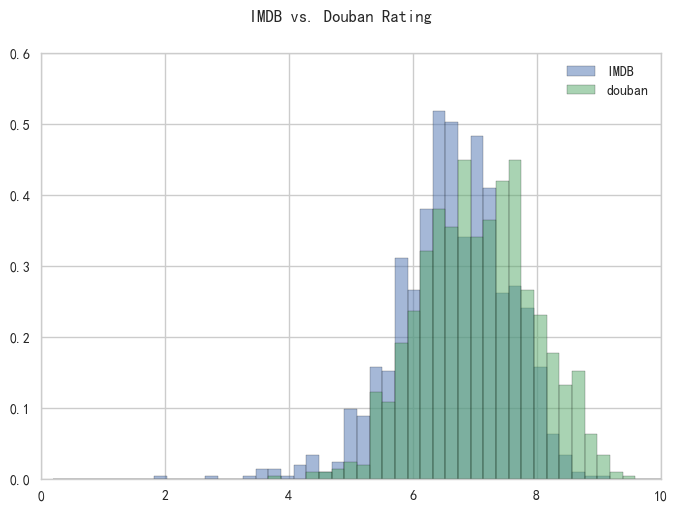

In [25]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5, normed=True, label = 'douban')
plt_configure(title='IMDB vs. Douban Rating', legend=True)

### 4.1.1 Best Movies

In [26]:
# df.sort_values(by='imdb_rating',ascending=False).head()
movie_list(df.sort_values(by='imdb_rating',ascending=False)[:20])

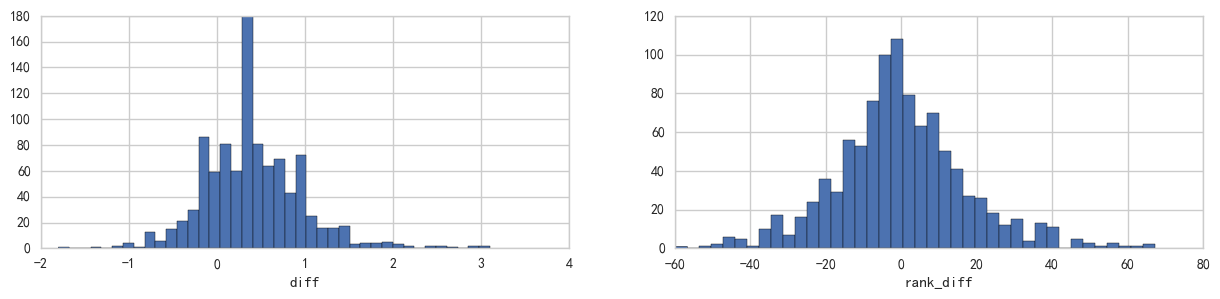

In [27]:
plt.subplot(1,2,1)
df['diff'].hist(bins=40,figsize=(15, 3))
plt.xlabel('diff')
plt.subplot(1,2,2)
df['rank_diff'].hist(bins=40)
plt.xlabel('rank_diff')

## 4.2 Scatter Comparison

### 4.2.1 Rating

 
0.7993 x + 1.009


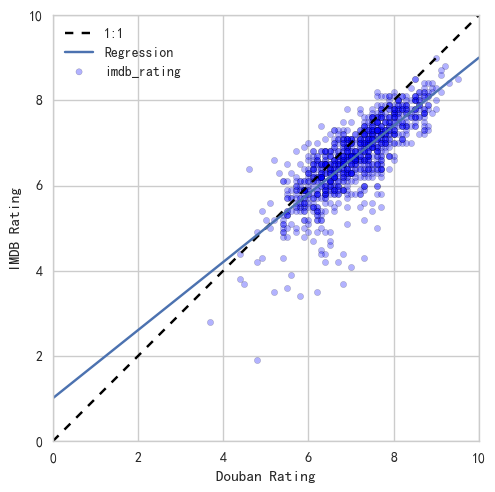

In [28]:
fig, fit_fn, scatter_plot = plot_movie_scatter_comparison(df, title='', type='rating')
print(fit_fn)
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare.html')

1. 对比前后scatter plot, 总体趋势是不变的
2. Play with the Scatter Plot， 看看有哪些电影差别很大:

    1. 回归线以上，IMDB >> 豆瓣；回归线以下，豆瓣 >> IMDB
    2. 总体而言，豆瓣评分确实更分散，(7,4.5)附近的一个cluster, 可以算作典型的偏离
    3. 这些偏离的电影，有何规律？

### 4.2.2 Normed Distribution

 
0.8307 x + 0.05221


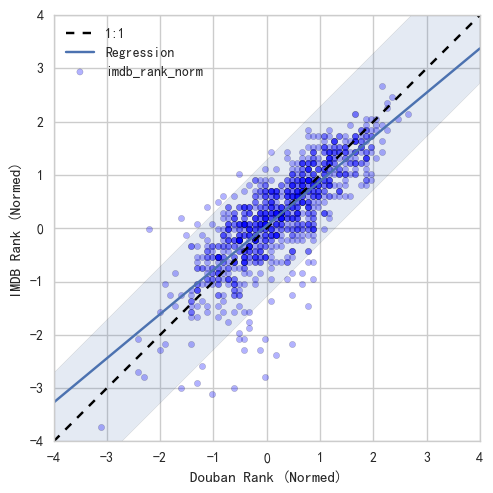

In [29]:
fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(df, title='', type='rank_norm')
print(fit_fn)
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_rank_norm.html')

### 4.2.3 Percentile

 
0.8152 x + 9.251


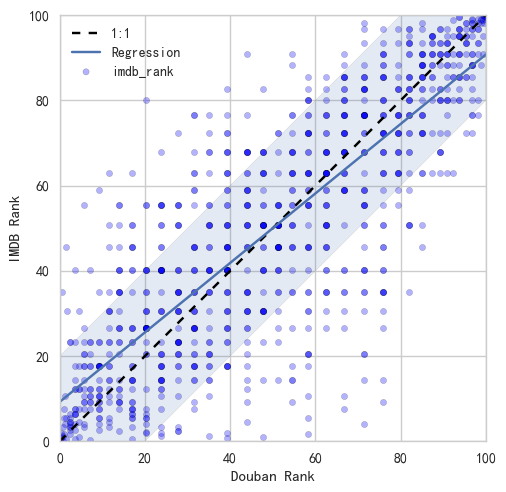

In [30]:
fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(df, title='', type='rank')
print(fit_fn)
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_rank.html')

## 4.3 Different Movies

以分位数为差别，是比较客观的看法

In [31]:
movie_list(df.sort_values(by='rank_diff_abs',ascending=False))

我观察到的规律: 似乎很多动画的评分，差别很大，例如：
1. 蓝精灵
2. Rio
3. 冰川时代
4. 疯狂原始人

那么，是不是存在某类电影，评分差别会很大？

接下来，按类别分析

# 5. Genre Comparison

In [32]:
sub_df = df[df['name'].str.contains("赛车总动员|里约大冒险|冰川时代|暮光之城|美食|赤壁")]
movie_list(sub_df.sort_values(by='rank_diff_abs',ascending=False))

In [33]:
def category_overview2(df, category_name, category, main=False):
    if main:
        mask = df[category_name].apply(lambda x: category in x[0:1])
    else:
        mask = df[category_name].apply(lambda x: category in x[0:2])
    sub_df = df[mask]
#     sub_df = df[df[category_name].str.contains(category)]
    fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(sub_df, legend=False)
    slope = fit_fn[1]
    mean_rank_diff = sub_df['rank_diff'].mean()
    print(category, len(sub_df), fit_fn, mean_rank_diff)
    return len(sub_df), slope, mean_rank_diff

In [34]:
# Documentary ineffective
categories = ['剧情','喜剧',  '动作', '爱情','犯罪', '动画', '科幻', '冒险','悬疑']
slopes = []
mean_deviations = []
for category in categories:
    movie_number, slope, mean_rank_diff = category_overview2(df, 'genre_douban',category)
    slopes.append(slope)
    mean_deviations.append(mean_rank_diff)
    plt_configure(title=category + ' (N: '+str(movie_number) +')')
    plt.gcf().set_size_inches(2.5,2.5)
align_figures()

剧情 468  
0.8053 x + 11.49 0.1461082276792275
喜剧 295  
0.8288 x + 2.287 6.093672657756836
动作 299  
0.7785 x + 14.31 -5.918688343488027
爱情 124  
0.8808 x + 2.544 4.000990806614048
犯罪 102  
0.8074 x + 12.52 -3.440751930177912
动画 55  
0.9943 x - 10.1 10.471482193536579
科幻 78  
0.7658 x + 15.96 -6.407674232447647
冒险 77  
0.833 x + 8.605 -2.4783876747622973
悬疑 64  
0.8507 x + 8.137 -1.4200969284994969


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAREAAAESCAYAAADaAOEgAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXl8U1Xe/9/ZkyZpQhegtIWWtrZAgbIvyiKIC64oI4z7
iDr6uD+OyzjjjDo6zoz6uPGM4vIbRXEBR3hwAUVlkWERBKRAKVBaWuhC1+x77u+PkDQhSZvSAEXy
fr36gpxz7rnf3CTfe885n/P9igRBEEiQIEGCE0R8ug1IkCDBmU3CiSRIkKBbJJxIggQJukXCiSRI
kKBbJJxIggQJukXCiSRIkKBbJJxIggQJukXCiSRIkKBbJJxIggQJukXCiZzhNDc3s2TJEiwWS0h5
WVkZL7/8cuC12WzG7XYD4Ha7efHFF6murgbA4/FgNpu7bcuBAwe63UdPwmKxUFtbe7rN6PGIErL3
nsczzzyDy+WKWFdcXMyvfvWrwOuysjJmzZrFxo0b6dWrV6B89erVPPzww2zduhWAMWPGYDabkUgk
gM+RSKXSwP9FIhFbtmxBo9GckM1lZWXMmzePTz75hOzs7BPqo6fxxRdf8Prrr/PJJ5+c8HU5G0g8
ifRAvvjiCywWCzqdLuRv7969AafgR6PRIBKJUCgUIeVKpRKlUonJZKKlpYUvv/yStWvXsnHjRjZu
3AjAG2+8wcaNG1m/fj1r1qw54R+K3W7nnnvu4amnniI7O5ulS5dSVFTEkiVLAm2OHDlCUVERy5Yt
O6FzdIbZbOb888+P2v8LL7zApEmTsFqtIeUbNmzgyiuvpKSkhGnTpvHmm28G6i677DImTJjAH//4
x5Ni8y8F6ek2IEE4crmcOXPmMGbMmJDyv//977S1tQEwYsQIXn31VQYOHAiASCQKtJs2bRpz5swB
4C9/+Qt6vR6RSMSHH36IQqFALBYjEom4//77EYvFOJ1OrrzySp5++ukTsvef//wno0ePZsaMGSHl
ixYtCnlqOpn84x//oL6+PmJdeXk57777Ls899xxJSUmB8sbGRu6//35uueUWxo8fT2lpKS+88AIa
jYbrrrsOgEceeYTLL7+cTZs2MX78+FPyXs40Ek6kByISiXj11VdDhicA+/btY8iQIQAoFAqUSmXY
sS0tLdTV1dG/f38ARo8ezb/+9S8+++wzHnnkkcBwpqioiLfeeouRI0cCviGN3W6P2GdHOJ1OPvro
I7766quwuvLycrZu3cro0aO71GdX2bhxI5999llU2//85z8zfPhwLr/88pDytWvX0qdPH+6++24A
Ro0axe7du/n2228DTkQul3P//ffzzjvvJJxIFBJOpIeSn58fcASvvvoqV111FXPmzCEnJ6fD4/bv
30/v3r1JTU0FYObMmQwYMIARI0YgEokCf1KplJtuuglBEAJ/M2fO5MUXX+ySnevXr2fIkCGkp6eH
1fXp04cPPvjgpDoRm83GE088wR133MH//d//hdV//PHHlJaW8umnn4bVtba2cvyUoMvlQi6Xh5RN
mzaNp556CpPJhFarje8b+AWQcCI9lJkzZwaGMwsWLAh53RHbt29n0KBBgdcajYYxY8awZcsWmpqa
AuX+H49/GJSZmRkyJIqV8vJyRowYEVYuEomYO3cu8+fP5+jRo1GPnz9/PgsXLuTHH3/s8rkBXnzx
RbRaLXfffXfYfEhrayv/8z//Q9++fVm4cCFyuZxf/epXFBcXAzBu3DheeuklPvroI6688kq2bNnC
6tWr+dvf/hbSj1KpJD8/n4qKCkpKSk7Izl8yCSfSA7FarSxYsIDPPvss7LXD4eDhhx+OeuzEiRMZ
NWpUyB1WLBZTWVnJtddeS0FBQUh7r9dLRUUFK1eu7PQpJxKNjY3k5+dHrJs1axbvvPMOH330EbNn
z47YZs6cOVxwwQVdPi/A1q1bWbJkCYsXLw4M04J54403MBqNSCQSmpqaKC8v59///jcvvfQSM2bM
YNiwYdx777089dRTPPXUUwDcdtttXHLJJWF9paWldegMz2YSTqSH4Xa7MZvN5OTkoNfrAZ8TSE9P
JzMzE5fLhUwmi3r8sGHDAMLu7HK5HJFIxOeffx5SbjKZGDt2bNgjfKyIxeKwIYEftVrN1VdfzZIl
S7jyyisjtklPT484FOoMh8PBH/7wB+68804KCwvD6r1eL0uXLiUrK4tly5ah0WhwuVzcfPPN/PWv
f2XGjBns3LmTN998k9/85jeMGDGC7du38+6775KRkcH1118f1p9YnFjMjETCifQw/AKwe+65J+BE
PvjgA66++uqYhjPR8P/Yi4qKwupEIlHEO3kspKend3iHvuGGG/jggw8iTrx2h5dffhmNRsMdd9wR
sb65uRmj0chtt90WWLqWyWTMmjWLP/3pT7S0tPD6669zzTXX8OijjwJw4YUXolQqeemll/j1r38d
4jQaGxvp3bt3XN/DL4WEE+lhlJeXo9FosFqt/POf/wR8Ooz333+fVatWMWjQIGbNmoXX68Xr9cbc
r39CtaysLKTcbDZ3a+JzyJAhzJ8/P2p9dnY2kydP5pNPPjmhOZdofP3119TV1QVWq/w89thjvPba
a4FJ1qysrJB6/wqOXC6nqqqK888/P6R+0KBBWCwWWlpaSEtLA3zX6ODBg1GHbWc7ieezHoZ/taOt
rY2FCxciEomYM2cOGRkZbN26lQ0bNgCELf+eKF1xRJEYP348hw4doqamJmqbm266iYaGhm6d53je
eustli5dyrJlywJ/6enp3Hfffbz11ltoNBpycnIoLy8POW7Tpk3k5OSg0Wjo1asXpaWlIfVr1qxB
oVCg0+kCZStWrGDcuHEhGpME7SSeRHoQLS0tfP3119xxxx3IZDJEIhG///3vA/XBYrOvv/4a8ClB
Y0UQhJCVG39Zd54QpFIp8+bN49lnn+WNN96I2GbChAmB1Y3jOXr0KC0tLRGHWR2Rl5cXViaTyejX
r19AgHf77bcHxHbFxcWsX7+eZcuW8cwzzwAwffp0XnjhBYxGIwMGDGDPnj2sX7+em266KTDvZDab
mT9/fuCpMEE4CSfSgzhw4AB2u53p06fj9XoDP/rg5dirrroq0H7Xrl3s3bs3Yl8ejyfktd9ZHD+c
ieRYusott9zCF198wfvvv8+NN94Ysc2NN97Ik08+GVa+ePHibi3xBnO8M7zmmmuQyWS8++67AfHe
ww8/zKxZswCYN28ecrmc9957j++++47k5GTmzJnDf//3fwO+a/P4449zwQUXhA2bEgQhJOhRfPPN
N4IgCEJZWZlQWFgYUvfKK68Ijz32WOD15ZdfLhQWFgpFRUWCw+EIabtq1Sph9OjRgdd79uwRioqK
Qtq4XC5h0aJFQlFRkdDU1NQtu48cOSJMmTJFqK6u7lY/PYnPPvtMuOGGGwSXy3W6TenRnNY5kZaW
FqZPnx6y3Xrfvn3Mnj2bcePG8fzzz4e076jul4J//4nD4Qi7s953330899xzgdclJSWIRCImTZoU
tkTrdDpDNuU5nc6wc0mlUr788kuuvvrqgML1ROnXrx/Lly//xezgBbjqqqt44403ArudE0TmtIUC
aGlp4a677mLnzp1899139OvXD6fTySWXXMLkyZO59dZbefbZZ7nooouYNWtWh3VnKy0tLchksoQU
O8Fp5bQ9iTz00ENhG6LWrVuH2WzmscceIzs7mwceeCCwnbyjurOVlJSUhANJcNo5bU7kmWee4YYb
bghRO+7du5eSkpLAY3hRUVFgRr+jugQJEpw+TttgLzMzM6zMYrGEiYMkEgkmk6nDuljvxm63G4PB
EIipkSDB2YbX68XhcKDT6eI219OjZowkEknYBKFCocBms0Wsk8vl2Gy2mJ2IwWCgqqoqXuYmSHDG
kpOT0+3JdD8

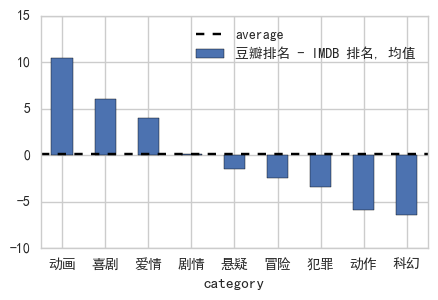

In [35]:
temp_df = pd.DataFrame({'category': categories, 'slope': slopes, 'mean_deviation': mean_deviations})
avg = np.average(mean_deviations)
temp_df.sort_values(by='mean_deviation',ascending=False).plot(x='category', y='mean_deviation', kind='bar', rot=0, label='豆瓣排名 - IMDB 排名, 均值')
plt.gca().axhline(avg, linestyle='--', color='black', label='average')
plt_configure(legend=True, figsize=(5,3))

可以发现，动画和其他类别，显著不同。具体画如下

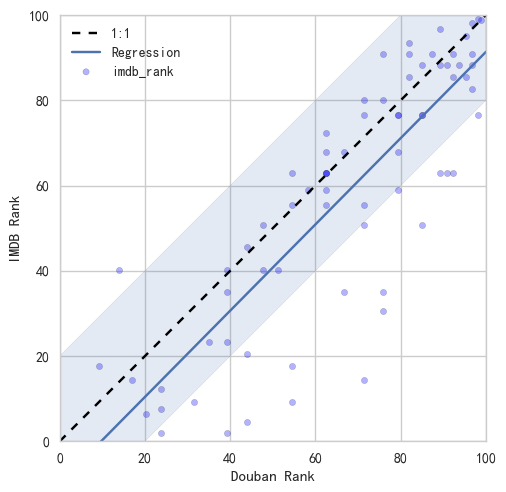

In [36]:
# sub_df = df[df['genre'].str.contains('Animation')]
sub_df = df[df['genre_douban'].apply(lambda x: '动画' in x)]
fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'animation_movies.html')

# 6. Country Comparison

In [37]:
slopes, mean_deviations = [], []
# Korea, India, Itlay is ineffecetive
countries = ['美国', '英国', '法国', '德国',"中国大陆","日本"]
for category in countries:
    try:
        movie_number, slope, mean_deviation = category_overview2(df, 'country_douban', category, main=True)
        slopes.append(slope)
        mean_deviations.append(mean_deviation)
        plt_configure(title=category + ' (N: '+str(movie_number) +')')
        plt.gcf().set_size_inches(2.5,2.5)
    except:
        print(category + 'not enough data')
align_figures()

美国 742  
0.8165 x + 8.224 0.4421109491507944
英国 91  
0.7473 x + 15.43 -1.1747064617155256
法国 45  
0.8582 x + 4.182 5.171757860579614
德国 13 Not available 2.033465024401581
中国大陆 13 Not available -12.460299016190255
日本 13 Not available -3.3271361065922993


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAREAAAESCAYAAADaAOEgAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXl8lNXV+L+z70s2kpAVEpJAWAKCgAWhKO4gFWtRqVqp
Vftq1Z9vq6WLS7Vvra9VKy7wFqsoIriA1AVFBcEFXCGsIQSyQRKyzWT29fn9Mcwkk5nJQgYTdb6f
Tz4w97nLeZ6ZOXPvPeeeIxIEQSBBggQJThHxYAuQIEGC7zYJJZIgQYIBkVAiCRIkGBAJJZIgQYIB
kVAiCRIkGBAJJZIgQYIBkVAiCRIkGBAJJZIgQYIBkVAiCRIkGBAJJTLEaWpqiiirr6/HbDYPgjQJ
EkSSUCJDmObmZi644AI+/vjjsPJ//OMf3HLLLYMkVWwOHz482CLEFZvNxvHjxwdbjCGPdLAFSBCJ
0+lEIpGQlpbGzTffzLp165gxYwYABw8eZMuWLbz++usA+Hw+/H4/Mpks1P7aa69l586diESiXscK
Hp26+OKLeeSRR05Z5gMHDrBkyRLWrl1LTk7OKfczlNiyZQtPP/00a9euRavVDrY4QxchwZDjiiuu
EIqLi4WSkpLQX3FxcdSykpIS4emnnw5rf8MNNwgPPfRQn8e7++67hbvvvvuU5XU4HMKcOXOE9957
TxAEQXj99deF4uJiYd26daE69fX1QnFxsbB+/fpTHqcrwTGi/cW6lwceeEBYvHhxWNlHH30kXHLJ
JUJpaakwbdq0iGf5l7/8RbjtttviIvP3lcRMZAiyatUqxGJx2Oxi7969XH311ezevTusbnAm0hWx
WBy6VllZiUqlQioNf6u9Xi9Op5Pi4uKwNqfCU089xeTJk5k7d25Y+erVq/npT396yv32xJw5c3jt
tdfCyjweDzfccANjx46NqP/111+zevVqJk+eHCqrqKjg1ltvZfr06SxZsoSvvvqKxx9/nKysLObN
mwfA7373O+bNm8eOHTuYNm3aabmX7zoJJTIEUSgUOJ1ORCJR6MsvRInY4PF4EAQBuVweVi6RSABo
b29n4cKFyOVyZDIZFosFpVKJTCbD4/Hg8XgoLy8HTl2JuN1u1qxZw9tvvx1xraKigi+//DLsixsv
DAYDBoMhrGzNmjXodDquuOKKCBmXLl2KRqMJK1+xYgUzZ85k2bJlACxYsIDKykrefffdkBKRy+Xc
dtttrFy5MqFEYpBQIkOUefPm0dLSEpqNeL1e3G43Z555JhBQKh6PhwsuuIC//e1vUftITU1l3759
oddz5szhnnvuYdasWXGT8+OPP6a0tJS0tLSIa+np6bz44ounRYl0x+PxsGLFCn7961+HzeAAHnvs
MUQiEYsWLQqbyd1+++0RisVoNOLz+cLK5syZw3333YfFYkGn052+m/iOklAiQ5TNmzeHvQ4uZz7/
/PN+9VNbW4sgCEgkEnw+Hy0tLRw7dgy3241SqSQzM3NAclZUVDBx4sSI8uCXdtmyZZw4cSJm+2XL
lrFq1ap+31d33nrrLdxuNwsWLAgrLy8v58UXX+SFF15g+/btYde6bwDb7Xa++uorfvWrX4WVK5VK
CgsLqaqqoqysbEByfh9JKJEhRkdHBz6fL2IPw2azAWCxWBAEIWR58fv9uN1udDodSqUyor9bb72V
2tpaZDIZVquVBx98EIlEgtvtZs6cOTz66KMDkre5uZnCwsKo137yk5+wcuVK1qxZw+WXXx61zs9+
9jPOPffcAckAgf2XK664ImwW4vF4+MMf/sC1117LhAkTIpRId5599ln8fn/UfZzU1NQeleEPmYQS
GWI89NBDvPPOO0gkkggTrUKh4JxzzgkrCy5rHn744YiNTYA33ngj9P/gciY7OxuTycQZZ5wxYHnF
YnHU/RoAjUbDZZddxiuvvMKll14atU5aWlrUpVB/KC8vZ//+/aG9jSBPPvkkALfddluvfRw6dIgV
K1bwm9/8BqPRGHHd7/cPaPP5+0xCiQwxHnzwQX7/+9+HNkODimTDhg289dZb/N///V9Y/eBeiVqt
7vMYH374IcuXL2f9+vUD9ulIS0vr8Rd68eLFvPjii1E3XuPFm2++ycSJE0lPTw+VHThwgH//+9+s
Xr06YlbXHZfLxW9/+1vGjx/PkiVLotZpbm5m2LBhcZX7+0JCiQwxmpqamDVrVkh5BH/9/H4/giAw
ZsyY0K+/IAj4/X6ysrL44IMPIvpqa2vDZDKFrDc+n4/W1lYuuugi9Ho9brcbi8UyIHlLS0sjZgBd
ycnJ4eyzz2bt2rV9cn7rL4IgsGnTJm644Yaw8g8++AC32x11GTV69GhWrVrFlClTALj33ntpampi
xYoVUWW0Wq0cOXIk5rLth05CiQwx0tPT+eabb5DL5SFTbUtLCxdeeCHjx4/HZrPx7LPPhs08XC5X
1L7WrVvHk08+iUKhCCmjoCVHEAS8Xi9/+ctfBiTvtGnT+O1vf0tdXV3MWc0111zDL37xi9OiRHbt
2kVzczOzZ88OK7/yyisj9lrWrFnDvn37ePDBB8nNzQVg+fLlbNy4keXLl4fNZLryzjvvMHXq1H7N
9n5IJJTIEESlUoX+39TUxK9+9SvOO+88HnzwQW6//XauvPJK/vGPf1BQUAAE9kq6EjRR3nTTTdx0
0029jvfJJ59EOKz1FalUypIlS3jwwQd55plnotaZPn16yLrRnRMnTtDW1kZJSckpjf/pp5+Smpoa
ocBSUlJISUkJK0tLS0OtVocc7L788ksef/xxLrzwQoxGI3v37gUCviFFRUVAYBaybNkynnrqqVOS
74dAYqdoiNLS0sIzzzzDJZdcQmlpKffffz8Ajz76KNOnT2fBggX89re/Zdu2bTgcjrC23f0c+sKp
tAly3XXX0djYyAsvvBCzzs9//vOo5evWreOaa6455bF37tzJpEmTTqntu+++iyAIvP322/z0pz8N
/d18881AYLa2dOlSzj33XEpLS09Zxu89g+FrH6S1tVWYM2eOcOzYsVBZRUWFsHDhQuHMM88U/v73
v4fV7+na94Xt27cLl1xyiVBSUiJcdtllwvbt26PW+/LLL4VFixYJxcXFwpgxY4TnnnsudO3666+P
OGcT6y9Y78477xyQ3MeOHRNmzZol1NbWDqifocTrr78uLF68WPB4PIMtypBm0JRIa2urcMUVVwgl
JSUhJeJyuYQ5c+YI9957r1BbWyvceOONwuuvv97rte8TbrdbeOKJJ4S9e/f2qf7hw4eFlStXChaL
JVR2zTXX9EvJ3n333cLtt9/eb1m7YzabB9zHUMLv9wtWq3WwxRjyDJoSue6664QXXnghTIls3rxZ
OPPMMwWn0ykIgiAcOHBAuPLKK3u9liAci8USek4JEpxuBm1P5IEHHmDx4sVhjkoHDx6krKwstFFY
UlIS2ozr6VqCcLRabcRma4IEp4tBs85kZWVFlNlsNrKzs8PKJBIJFoulx2t9PRTl9Xoxm81hJs8E
CX5I+P1+XC4XBoOhVye8vjKkTLwSiSTiWLtCocDhcES9JpfLcTgcfVYiZrOZ6urqeImbIMF3lvz8
/AgT+KkypJSIwWCIiNNptVqRyWRRr9lstohj3z0RnOKnpqYOqXB3LpeLhoYGMjMzh9wy5Ickm9Vq
54svrMjlnSeb3e4GpkzRotX23dGstd2EzeGjta2N9GHpET9+VqudXbvsyOUZXcZppKxM3eM4e/c0
YHcE/GG2bz2IXxh/8kobPq8ciVRLa8tmvN4CxJIswEVri5UO8+e43Y8CbvLzi3jwwXvi+l4OKSUy
btw4XnnlldDruro6PB4PRqOxx2t9JbiE0Wq1cdPC8cBut9PQ0IDRaBxyXpE/JNn27TOhUIwOK1Mo
jNTUVHH22X0

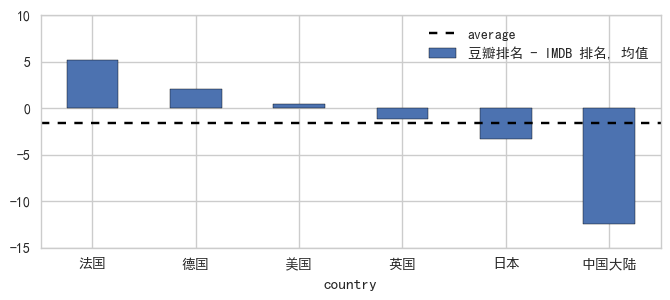

In [38]:
temp_df = pd.DataFrame({'country': countries, 'slope': slopes, 'mean_deviation': mean_deviations})
avg = np.average(mean_deviations)
temp_df.sort_values(by='mean_deviation',ascending=False).plot(x='country', y='mean_deviation', kind='bar', rot=0, label='豆瓣排名 - IMDB 排名, 均值')
plt.gca().axhline(avg, linestyle='--', color='black', label='average')
plt_configure(legend=True,figsize=(8,3))

17 o


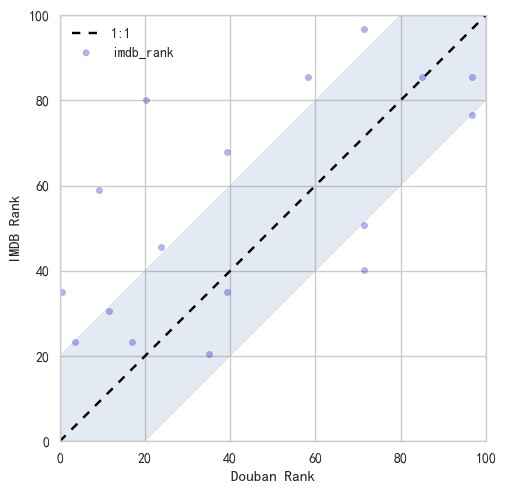

In [39]:
country='中国'
sub_df = df[df['country_douban'].apply(lambda x: any(country in x[0] for country in ['香港', '中国大陆','台湾']))]
fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(sub_df)
print(len(sub_df), fit_fn[1])
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'china_movies.html')

In [40]:
sub_df

,movie_tt_id,name,imdb_rating,metascore,year,imdb_ratings_count,genre,country,db_rating,db_ratings_count,...,genre_douban,country_douban,db_rank_norm,imdb_rank_norm,diff,diff_abs,imdb_rank,db_rank,rank_diff,rank_diff_abs
64,tt0765120,蓝莓之夜,6.7,5.2,2007.0,41320,"Drama, Romance","Hong Kong, China, France",7.6,103493,...,"[剧情, 爱情]","[中国大陆, 香港, 法国]",0.769541,0.296098,0.9,0.9,50.654582,71.299094,20.644512,20.644512
571,tt0375568,阿童木,6.4,5.3,2009.0,23227,"Animation, Action, Family","Hong Kong, USA, Japan",6.8,38047,...,"[动画, 动作, 家庭]","[香港, 美国, 日本]",-0.024698,-0.013459,0.4,0.4,34.994965,39.274924,4.279960,4.279960
601,tt0425637,赤壁(上),7.4,7.3,2008.0,33997,"Action, Adventure, Drama","China, Hong Kong, Japan, Taiwan, South Korea",6.3,112779,...,"[动作, 冒险, 剧情]","[中国大陆, 香港, 台湾, 日本, 韩国]",-0.521097,1.018398,-1.1,1.1,80.010070,20.140987,-59.869084,59.869084
731,tt0913968,投名状,7.1,7.0,2007.0,21648,"Action, Drama, History","Hong Kong, China",6.8,85659,...,"[剧情, 动作, 战争]","[中国大陆, 香港]",-0.024698,0.708841,-0.3,0.3,67.824773,39.274924,-28.549849,28.549849
966,tt1220719,叶问,8.1,5.9,2008.0,135456,"Action, Biography, Drama","Hong Kong, China",7.6,166281,...,"[动作, 传记, 剧情]","[香港, 中国大陆]",0.769541,1.740698,-0.5,0.5,96.777442,71.299094,-25.478348,25.478348
1099,tt1386932,叶问2：宗师传奇,7.6,6.7,2010.0,54925,"Action, Biography, Drama","Hong Kong, China",7.3,122905,...,"[动作, 传记, 历史]","[中国大陆, 香港]",0.471702,1.224769,-0.3,0.3,85.548842,58.207452,-27.341390,27.341390
1222,tt1456661,精武风云·陈真,6.3,4.9,2010.0,7376,"Action, Drama, History","Hong Kong, China",6.0,52072,...,[动作],"[香港, 中国大陆]",-0.818936,-0.116645,-0.3,0.3,30.563948,11.480363,-19.083585,19.083585
1264,tt1425257,苏乞儿,6.4,6.2,2010.0,6840,"Action, Drama, History",China,4.6,36179,...,"[动作, 剧情, 历史]","[中国大陆, 香港]",-2.208854,-0.013459,-1.8,1.8,34.994965,0.503525,-34.491440,34.491440
1434,tt1123373,狄仁杰之通天帝国,6.6,7.5,2010.0,7533,"Action, Adventure, Drama","China, Hong Kong",6.4,128756,...,"[剧情, 动作, 犯罪]","[中国大陆, 香港]",-0.421817,0.192912,-0.2,0.2,45.518630,23.867069,-21.651561,21.651561
1449,tt1533749,新少林寺,6.9,5.3,2011.0,14722,"Action, Drama","Hong Kong, China",5.9,69104,...,"[剧情, 动作]","[中国大陆, 香港]",-0.918216,0.502469,-1.0,1.0,59.013092,9.164149,-49.848943,49.848943


In [41]:
movie_list(sub_df.sort_values(by='rank_diff_abs',ascending=False))

20 0.586504282124


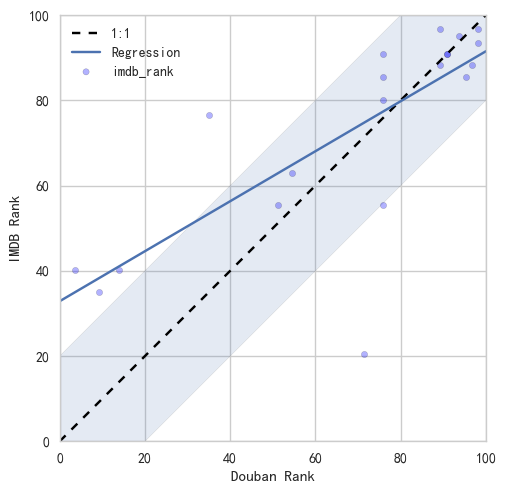

In [42]:
country='亚洲'
sub_df = df[df['country_douban'].apply(lambda x: any(country in x[0:1] for country in ['日本', '韩国','印度']))]
fig, fit_fn , scatter_plot = plot_movie_scatter_comparison(sub_df)
print(len(sub_df), fit_fn[1])
plt.show()
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'asia_movies.html')

In [43]:
movie_list(sub_df.sort_values(by='rank_diff_abs',ascending=False))

整体而言，其实评价有好有坏。
- 大部分略微偏低，但总体一致。可以认为是文化差异，东方文化魅力在国外会有加成
- 好的电影，像叶问一致评价都是较高的。
- 另外也存在一些文化差异，导致评分有明显差别的，比如让子弹飞、一代宗师